<a href="https://colab.research.google.com/github/lannaelvira77/WeatherWise-LannaElvira-23486942/blob/main/starter_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌦️ WeatherWise: Intelligent Weather Analysis & Advisory System

Welcome to your **WeatherWise** project notebook!



## 🧰 Setup and Imports


In [44]:
# matplotlib for temperature and precipitation visualisations
# pyinputplus for console-style user interface (menu input validation)

!pip install matplotlib pyinputplus


In [45]:
# ntlk for more advanced NLP

!pip install nltk

## 📦 Setup and Configuration

In [9]:
# Store and Test the Connection to OpenWeatherMap API

import requests

# API Key
api_key = "3940901d1d76b912b0cd840fd2b06ff7"

# Test the Location
location = "Perth,AU"

# Build the API request URL
url = f"http://api.openweathermap.org/data/2.5/weather?q={location}&appid={api_key}&units=metric"

# Send the request
response = requests.get(url)

# Convert to JSON
data = response.json()

# Display result
print(data)

{'coord': {'lon': 115.8333, 'lat': -31.9333}, 'weather': [{'id': 520, 'main': 'Rain', 'description': 'light intensity shower rain', 'icon': '09d'}], 'base': 'stations', 'main': {'temp': 17.08, 'feels_like': 16.93, 'temp_min': 16.67, 'temp_max': 17.8, 'pressure': 1012, 'humidity': 80, 'sea_level': 1012, 'grnd_level': 1009}, 'visibility': 8000, 'wind': {'speed': 7.2, 'deg': 230}, 'rain': {'1h': 0.38}, 'clouds': {'all': 75}, 'dt': 1759563791, 'sys': {'type': 2, 'id': 63154, 'country': 'AU', 'sunrise': 1759528243, 'sunset': 1759573200}, 'timezone': 28800, 'id': 2063523, 'name': 'Perth', 'cod': 200}


## 🌤️ Weather Data Functions

This function will:
1. Retrieve current weather and 5-day forecast from OpenWeatherMap API (v2.5)
2. Convert the JSON response into a clean dictionary
3. Error handling: invalid city names, network errors, and forecast limit (1-5 days)
4. Good modular structure

In [52]:
import os, requests
from datetime import datetime, timezone
from collections import defaultdict
import time

_WEATHER_CACHE = {}
_CACHE_TTL_SECONDS = 600  # 10 minutes
_RETRY_STATUS = {502, 503, 504}  # transient
_DEFAULT_TIMEOUT = 20

def _now_utc():
    return datetime.now(timezone.utc)

def _make_error(message, code=None, hint=None):
    """Standard error payload the UI can render."""
    return {"error": {"message": message, "code": code, "hint": hint}}

def _safe_get(d, path, default=None):
    cur = d
    for p in path:
        if not isinstance(cur, dict) or p not in cur:
            return default
        cur = cur[p]
    return cur

def _aggregate_daily_from_3h(forecast_json, forecast_days):
    three_hour_list = forecast_json.get("list", [])
    buckets = defaultdict(list)
    for item in three_hour_list:
        dt_txt = item.get("dt_txt")
        if not dt_txt:
            continue
        day = dt_txt.split(" ")[0]
        buckets[day].append(item)

    daily_rows = []
    for day in sorted(buckets.keys()):
        rows = buckets[day]
        temps = [_safe_get(x, ["main","temp"]) for x in rows if _safe_get(x, ["main","temp"]) is not None]
        pops  = [x.get("pop") for x in rows if isinstance(x.get("pop"), (int, float))]
        descs = [_safe_get(x, ["weather"], [{}])[0].get("description") for x in rows if _safe_get(x, ["weather"], [{}])]
        icons = [_safe_get(x, ["weather"], [{}])[0].get("icon") for x in rows if _safe_get(x, ["weather"], [{}])]
        if not temps:
            continue
        temp_min, temp_max = min(temps), max(temps)
        temp_avg = sum(temps) / len(temps)
        pop_avg = (sum(pops) / len(pops) * 100.0) if pops else 0.0

        def _most_common(lst):
            if not lst: return None
            c = {}
            for v in lst: c[v] = c.get(v, 0) + 1
            return max(c, key=c.get)

        description = (_most_common([d for d in descs if d]) or (descs[0] if descs else "") or "").capitalize()
        icon = _most_common([i for i in icons if i]) or (icons[0] if icons else "")

        daily_rows.append({
            "date": day,
            "temp_min": round(temp_min, 2),
            "temp_max": round(temp_max, 2),
            "temp_avg": round(temp_avg, 2),
            "pop": round(pop_avg, 1),
            "description": description,
            "icon": icon
        })
    return daily_rows[:max(1, min(int(forecast_days), 5))]

def _http_get_with_retry(url, params, timeout=_DEFAULT_TIMEOUT, retries=1):
    """Tiny retry for transient 5xx."""
    for attempt in range(retries + 1):
        try:
            r = requests.get(url, params=params, timeout=timeout)
            return r
        except requests.exceptions.RequestException as e:
            if attempt >= retries:
                raise
            time.sleep(0.8)  # backoff
    # unreachable
    return None

def get_weather_data(location, forecast_days=5, include_hourly_24h=True, use_cache=True):
    """
    Retrieve weather data (OpenWeatherMap v2.5) and return a hybrid-friendly dict.

    Returns either a data dict or {"error": {...}} for the UI to render nicely.
    """
    # ---- Input validation ----
    if not isinstance(location, str) or not location.strip():
        return _make_error("Please provide a city name (e.g., 'Perth,AU').", code="bad_input")
    location = location.strip()
    try:
        forecast_days = int(forecast_days)
    except Exception:
        return _make_error("forecast_days must be an integer between 1 and 5.", code="bad_input")
    if not (1 <= forecast_days <= 5):
        return _make_error("forecast_days must be between 1 and 5.", code="bad_input")

    api_key = os.environ.get("OWM_API_KEY")
    if not api_key:
        return _make_error("Missing API key. Set OWM_API_KEY.", code="missing_api_key",
                           hint="In Colab: os.environ['OWM_API_KEY'] = '...your key...'")

    base_url_current = "https://api.openweathermap.org/data/2.5/weather"
    base_url_forecast = "https://api.openweathermap.org/data/2.5/forecast"
    params = {"q": location, "appid": api_key, "units": "metric"}

    # ---- Cache ----
    cache_key = (location.lower(), forecast_days)
    if use_cache and cache_key in _WEATHER_CACHE:
        cached = _WEATHER_CACHE[cache_key]
        if (_now_utc() - cached["fetched_at"]).total_seconds() < _CACHE_TTL_SECONDS:
            return cached["data"]

    # ---- API calls with graceful errors ----
    try:
        cur_res = _http_get_with_retry(base_url_current, params, retries=1)
        if cur_res.status_code in _RETRY_STATUS:
            cur_res = _http_get_with_retry(base_url_current, params, retries=1)
        if cur_res.status_code == 401:
            return _make_error("Invalid API key (401). Check OWM_API_KEY.", code=401)
        if cur_res.status_code == 404:
            return _make_error(f"City not found: '{location}'.", code=404,
                               hint="Try 'City,CountryCode' e.g., 'Perth,AU'.")
        if cur_res.status_code == 429:
            return _make_error("Rate limit exceeded (429). Please try again shortly.", code=429)
        cur_res.raise_for_status()

        fct_res = _http_get_with_retry(base_url_forecast, params, retries=1)
        if fct_res.status_code in _RETRY_STATUS:
            fct_res = _http_get_with_retry(base_url_forecast, params, retries=1)
        fct_res.raise_for_status()

    except requests.exceptions.Timeout:
        return _make_error("The weather service timed out. Please try again.", code="timeout")
    except requests.exceptions.RequestException as e:
        return _make_error(f"Network error: {e}", code="network")

    # ---- Parse JSON, handle provider-level errors ----
    cur_json = cur_res.json()
    fct_json = fct_res.json()

    # Sometimes OWM returns {"cod":"404", ...} even with 200 HTTP
    cod = cur_json.get("cod")
    if str(cod) != "200":
        return _make_error(cur_json.get("message", "Unknown error from provider."), code=cod)

    fetched_at = _now_utc().isoformat()
    loc_name = cur_json.get("name", location)
    loc_country = _safe_get(cur_json, ["sys","country"], "")
    lat = _safe_get(cur_json, ["coord","lat"])
    lon = _safe_get(cur_json, ["coord","lon"])
    tz_seconds = _safe_get(cur_json, ["timezone"], 0)

    weather0 = _safe_get(cur_json, ["weather"], [{}])[0] or {}
    current = {
        "temp": round(_safe_get(cur_json, ["main","temp"], 0.0), 2),
        "description": weather0.get("description", "").capitalize(),
        "humidity": _safe_get(cur_json, ["main","humidity"], 0),
        "wind_speed": _safe_get(cur_json, ["wind","speed"], 0.0),
        "icon": weather0.get("icon", ""),
        "sunrise": _safe_get(cur_json, ["sys","sunrise"]),
        "sunset": _safe_get(cur_json, ["sys","sunset"]),
    }
    current["summary"] = f"{current['temp']}°C, {current['description']} (Humidity {current['humidity']}%, Wind {current['wind_speed']} m/s)"

    daily = _aggregate_daily_from_3h(fct_json, forecast_days)

    hourly_24h = None
    if include_hourly_24h:
        slots = (fct_json.get("list") or [])[:8]
        hourly_24h = []
        for it in slots:
            w0 = _safe_get(it, ["weather"], [{}])[0] or {}
            hourly_24h.append({
                "dt": it.get("dt_txt"),
                "temp": round(_safe_get(it, ["main","temp"], 0.0), 2),
                "pop": round((it.get("pop") or 0) * 100.0, 1),
                "description": (w0.get("description") or "").capitalize(),
                "icon": w0.get("icon", "")
            })

    data = {
        "meta": {"provider": "OpenWeatherMap", "fetched_at_utc": fetched_at, "units": "metric"},
        "location": {"query": location, "name": loc_name, "country": loc_country, "lat": lat, "lon": lon,
                     "timezone_offset_seconds": tz_seconds},
        "current": current,
        "daily": daily,
    }
    if hourly_24h is not None:
        data["hourly_24h"] = hourly_24h

    if use_cache:
        _WEATHER_CACHE[cache_key] = {"data": data, "fetched_at": _now_utc()}

    return data

# Optional helpers for your UI/tests
def weather_cache_info():
    return {"entries": len(_WEATHER_CACHE), "ttl_seconds": _CACHE_TTL_SECONDS}

def weather_cache_clear():
    _WEATHER_CACHE.clear()


#Test The Functions
import json

# Happy path
ok = get_weather_data("Perth,AU", 3)
print(json.dumps(ok, indent=2)[:600], "...")

# Bad city
bad = get_weather_data("NoSuchCityZZ,AU", 3)
print(bad)

# Bad forecast_days
bad_days = get_weather_data("Perth,AU", 9)
print(bad_days)

{
  "meta": {
    "provider": "OpenWeatherMap",
    "fetched_at_utc": "2025-10-04T09:28:50.278071+00:00",
    "units": "metric"
  },
  "location": {
    "query": "Perth,AU",
    "name": "Perth",
    "country": "AU",
    "lat": -31.9333,
    "lon": 115.8333,
    "timezone_offset_seconds": 28800
  },
  "current": {
    "temp": 16.73,
    "description": "Light rain",
    "humidity": 79,
    "wind_speed": 2.57,
    "icon": "10d",
    "sunrise": 1759528243,
    "sunset": 1759573200,
    "summary": "16.73\u00b0C, Light rain (Humidity 79%, Wind 2.57 m/s)"
  },
  "daily": [
    {
      "date": "2025-1 ...
{'error': {'message': "City not found: 'NoSuchCityZZ,AU'.", 'code': 404, 'hint': "Try 'City,CountryCode' e.g., 'Perth,AU'."}}
{'error': {'message': 'forecast_days must be between 1 and 5.', 'code': 'bad_input', 'hint': None}}


In [72]:
# ===== Extensions: Historical data scaffolding =====
def get_historical_weather_data(location: str, start_date: str, days: int = 3):
    """
    Historical weather data (scaffold).
    Replace with a real provider (e.g., OWM history, Meteostat) when ready.
    Returns {"error": {...}} for now to keep UI stable.
    """
    ok, note = validate_location_format(location)
    if not ok:
        return {"error": {"message": note, "code": "bad_input"}}
    try:
        _ = datetime.strptime(start_date, "%Y-%m-%d")
    except Exception:
        return {"error": {"message": "start_date must be 'YYYY-MM-DD'.", "code": "bad_input"}}

    return {
        "error": {
            "message": "Historical provider not configured yet.",
            "code": "not_implemented",
            "hint": "Connect a history API and map it to the same structure as get_weather_data()."
        }
    }

## Shared Validators & Data Helpers

In [71]:
# ===== Extensions: Shared helpers =====
import re
from datetime import datetime, timedelta, timezone

def validate_location_format(loc: str) -> tuple[bool, str | None]:
    """
    Basic sanity check for 'City' or 'City,CC' (CC=country code).
    We keep it permissive; API will still be the source of truth.
    """
    if not isinstance(loc, str) or not loc.strip():
        return False, "Please enter a non-empty city name (e.g., 'Perth,AU')."
    loc = loc.strip()
    if len(loc) < 2:
        return False, "City name seems too short."
    # Allow letters, spaces, hyphens, dots, apostrophes, comma + 2-letter CC
    if not re.match(r"^[A-Za-z .'\-]+(,\s*[A-Za-z]{2})?$", loc):
        return True, "Note: unusual city format; attempting lookup anyway."
    return True, None

def daterange(start_date: datetime, days: int):
    for i in range(days):
        yield start_date + timedelta(days=i)

# ===== Extensions: Activity recommendation (e.g., hiking) =====
def score_hiking_day(day: dict) -> tuple[int, list[str]]:
    """
    Score a day (0-100) for hiking using simple heuristics:
      - Too hot/cold reduces score
      - Rain chance reduces score
      - Moderate wind is fine; very windy reduces
    """
    reasons = []
    score = 100

    t_avg = day.get("temp_avg")
    t_min = day.get("temp_min")
    t_max = day.get("temp_max")
    pop   = day.get("pop", 0.0)           # %
    # Wind not available per-day in free OWM feed—leave note
    windy = None

    # Temperature comfort band
    if t_avg is not None:
        if t_avg < 5:   score -= 35; reasons.append("very cold")
        elif t_avg < 12: score -= 15; reasons.append("cool")
        elif t_avg > 35: score -= 30; reasons.append("extreme heat")
        elif t_avg > 30: score -= 15; reasons.append("hot")

    # Precipitation
    if pop >= 70: score -= 40; reasons.append("high rain chance")
    elif pop >= 40: score -= 20; reasons.append("possible showers")

    # Wind (not daily here). If you later add daily wind, apply it:
    # if wind_speed and wind_speed > 10: score -= 15; reasons.append("windy")

    # Clamp
    score = max(0, min(100, score))
    return score, reasons

def recommend_activity(weather_data: dict, activity: str = "hiking", days: int | None = None) -> str:
    """
    Return a short human-readable recommendation summary for the next N days.
    For now only 'hiking' has scoring logic; easily extended for others.
    """
    if not isinstance(weather_data, dict) or "error" in weather_data:
        return "I can't assess activities right now due to missing weather data."

    daily = weather_data.get("daily") or []
    if not daily:
        return "No multi-day forecast available to make a recommendation."

    k = max(1, min(days or len(daily), len(daily)))
    daily = daily[:k]

    if activity.lower() != "hiking":
        return f"I don't have a model for {activity} yet—try 'hiking'."

    lines = []
    best = None
    for d in daily:
        score, reasons = score_hiking_day(d)
        tag = "✅ Good" if score >= 75 else ("⚠️ Fair" if score >= 50 else "❌ Poor")
        reason_txt = (", ".join(reasons) if reasons else "conditions look fine")
        lines.append(f"{d['date']}: {tag} ({score}/100) — {reason_txt}")
        best = max(best or (score, d['date']), (score, d['date']))

    summary = f"Recommendation for hiking in {weather_data['location']['name']} (next {k} days):\n" + "\n".join("- " + x for x in lines)
    if best:
        summary += f"\n\nBest day: {best[1]} (score {best[0]}/100)."
    return summary

# ===== Extensions: Calendar integration stubs =====
def is_day_good_for_event(weather_data: dict, target_date: str, activity="outdoor"):
    """
    Check a specific date in the 'daily' forecast and return a simple verdict string.
    """
    daily = (weather_data or {}).get("daily") or []
    for d in daily:
        if d.get("date") == target_date:
            # very simple: if rain chance < 40% and not extreme heat/cold
            pop = d.get("pop", 0)
            t = d.get("temp_avg", 20)
            ok_temp = 8 <= t <= 32
            verdict = (pop < 40 and ok_temp)
            return verdict, f"{'Good' if verdict else 'Not ideal'} for {activity.lower()} — {t:.0f}°C, rain {pop:.0f}%."
    return None, "That date is not in the current forecast window."

def add_event_placeholder(title: str, date_str: str, location: str):
    """
    Placeholder for calendar integration: in real use, push to Google Calendar API or save .ics.
    """
    return f"(Stub) Would add event '{title}' on {date_str} for {location}."

## 📊 Visualisation Functions

In [76]:
# ---- Visualisation theme helpers ----
DEFAULT_THEME = {
    "temp_line": "orange",
    "hourly_line": "orange",
    "rain_bar": "skyblue",
    "tmin_line": "blue",
    "tmax_line": "red",
    "bar_edge": "black",
    "grid_alpha": 0.6,
}

def apply_theme_color(theme: dict | None, key: str, fallback: str | None = None):
    """Return themed color if provided, otherwise the fallback."""
    if isinstance(theme, dict) and key in theme:
        return theme[key]
    return fallback

### Temperature Trend Visualisation

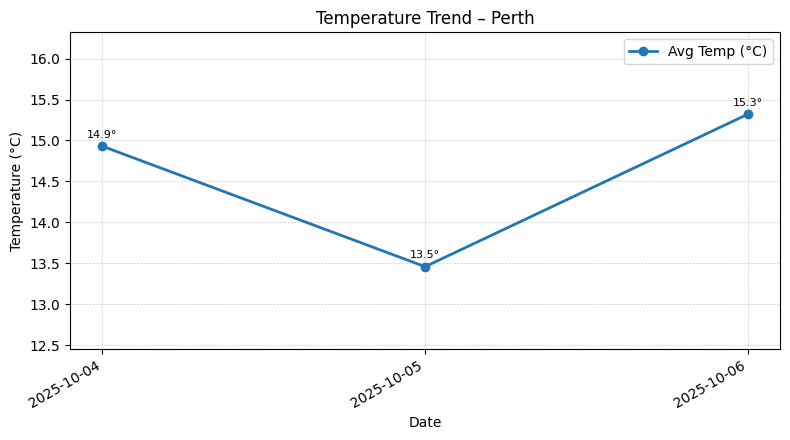

In [78]:
import matplotlib.pyplot as plt
from datetime import datetime

def create_temperature_visualisation(weather_data, output_type='display', theme=None):
    """
    Create a visualisation of the temperature trend over the forecast period.
    Line chart of daily average temperature with labels, legend, and guards.

    Args:
        weather_data (dict): Processed weather data from get_weather_data().
            Expected daily structure (preferred):
                weather_data["daily"] = [
                    {"date":"YYYY-MM-DD","temp_avg":float,"temp_min":float,"temp_max":float, ...}, ...
                ]
            Fallback (simpler schema):
                weather_data["forecast"] = [
                    {"date":"YYYY-MM-DD","temp":float, ...}, ...
                ]
        output_type (str): 'display' to show the chart, or 'figure' to return the Matplotlib figure.

    Returns:
        If output_type == 'figure': returns a matplotlib.figure.Figure
        Otherwise: displays the chart and returns None
    """
    # ---- Guards ----
    if not isinstance(weather_data, dict) or "error" in weather_data:
        print("⚠️ Cannot create visualisation: missing or invalid weather data.")
        return None

    title_location = weather_data.get("location", {}).get("name") or weather_data.get("location", "") or "Selected Location"

    # Prefer enhanced schema
    daily = weather_data.get("daily") or []
    dates, temps = [], []
    if daily:
        for row in daily:
            d = row.get("date")
            t = row.get("temp_avg", row.get("temp"))
            if d is None or t is None:
                continue
            dates.append(d)
            temps.append(float(t))
    else:
        # Fallback simple schema
        for row in weather_data.get("forecast", []):
            d, t = row.get("date"), row.get("temp")
            if d is None or t is None:
                continue
            dates.append(d); temps.append(float(t))

    if not dates or not temps:
        print("ℹ️ No temperature data available.")
        return None

    # Ensure chronological order
    try:
        pairs = sorted([(datetime.strptime(d, "%Y-%m-%d"), t) for d, t in zip(dates, temps)], key=lambda x: x[0])
        dates = [dt.strftime("%Y-%m-%d") for dt, _ in pairs]
        temps = [t for _, t in pairs]
    except Exception:
        pass

    fig, ax = plt.subplots(figsize=(8, 4.5))
    ax.plot(dates, temps, marker='o', linewidth=2, label="Avg Temp (°C)")
    ax.set_title(f"Temperature Trend – {title_location}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Temperature (°C)")
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
    ax.legend(loc="best")

    # Annotate points
    for x, y in zip(dates, temps):
        ax.annotate(f"{y:.1f}°", xy=(x, y), xytext=(0, 6), textcoords="offset points", ha="center", fontsize=8)

    # Y padding for extremes
    ymin, ymax = min(temps), max(temps)
    if ymin == ymax:
        ymin -= 2; ymax += 2
    ax.set_ylim(ymin - 1.0, ymax + 1.0)

    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()
    if output_type == 'figure': return fig
    plt.show(); plt.close(fig); return None

# Sample test input using existing data dict:
data = get_weather_data("Perth,AU", forecast_days=3)
create_temperature_visualisation(data)                 # displays chart

### Precipitation Probability Visualisation



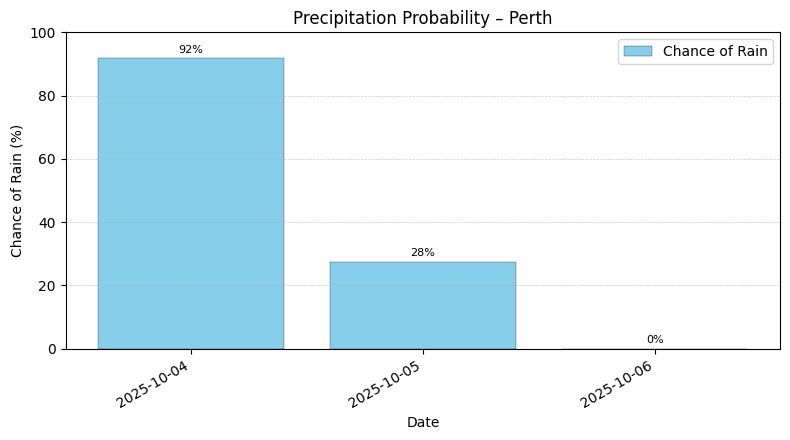

In [80]:
import matplotlib.pyplot as plt
from datetime import datetime

def create_precipitation_visualisation(weather_data, output_type='display', theme=None):
    """
    Create a visualisation of daily precipitation (rain) probability over the forecast period.
    Bar chart of % chance of rain (POP) with legend, labels, edge cases.

    Args:
        weather_data (dict): Processed weather data from get_weather_data().
            Expected daily structure:
                weather_data["daily"] = [
                    {"date":"YYYY-MM-DD","pop":float, ...}, ...
                ]
            Fallback structure:
                weather_data["forecast"] = [
                    {"date":"YYYY-MM-DD","description":str}, ...
                ]
        output_type (str): 'display' to show the chart, or 'figure' to return the Matplotlib figure.

    Returns:
        If output_type == 'figure': returns a matplotlib.figure.Figure
        Otherwise: displays the chart and returns None
    """
    if not isinstance(weather_data, dict) or "error" in weather_data:
        print("⚠️ Cannot create visualisation: missing or invalid weather data.")
        return None

    title_location = weather_data.get("location", {}).get("name") or weather_data.get("location", "") or "Selected Location"

    dates, pops = [], []
    daily = weather_data.get("daily") or []
    if daily:
        for row in daily:
            d, p = row.get("date"), row.get("pop")
            if d is None or p is None:
                continue
            dates.append(d); pops.append(float(p))
    else:
        # Fallback heuristic if only descriptions exist
        for row in weather_data.get("forecast", []):
            d = row.get("date"); desc = (row.get("description") or "").lower()
            if not d: continue
            if "rain" in desc or "shower" in desc: prob = 60.0
            elif "cloud" in desc: prob = 30.0
            else: prob = 10.0
            dates.append(d); pops.append(prob)

    if not dates or not pops:
        print("ℹ️ No precipitation data available for this period.")
        return None

    # Sort chronologically
    try:
        pairs = sorted([(datetime.strptime(d, "%Y-%m-%d"), p) for d, p in zip(dates, pops)], key=lambda x: x[0])
        dates = [dt.strftime("%Y-%m-%d") for dt, _ in pairs]
        pops = [p for _, p in pairs]
    except Exception:
        pass

    if sum(pops) == 0:
        print("ℹ️ Precipitation probability is 0% across the selected days.")
        # Still show a flat chart for clarity
    fig, ax = plt.subplots(figsize=(8, 4.5))
    ax.bar(dates, pops, label="Chance of Rain", color="skyblue", edgecolor="black", linewidth=0.2)
    ax.set_title(f"Precipitation Probability – {title_location}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Chance of Rain (%)")
    ax.set_ylim(0, 100)
    ax.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.6)
    ax.legend(loc="best")

    for i, v in enumerate(pops):
        ax.text(i, v + 1, f"{v:.0f}%", ha='center', va='bottom', fontsize=8)

    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()
    if output_type == 'figure': return fig
    plt.show(); plt.close(fig); return None


# Sample test input using existing data dict:
data = get_weather_data("Perth,AU", forecast_days=3)
create_precipitation_visualisation(data)

### Temperature Range Visualisation

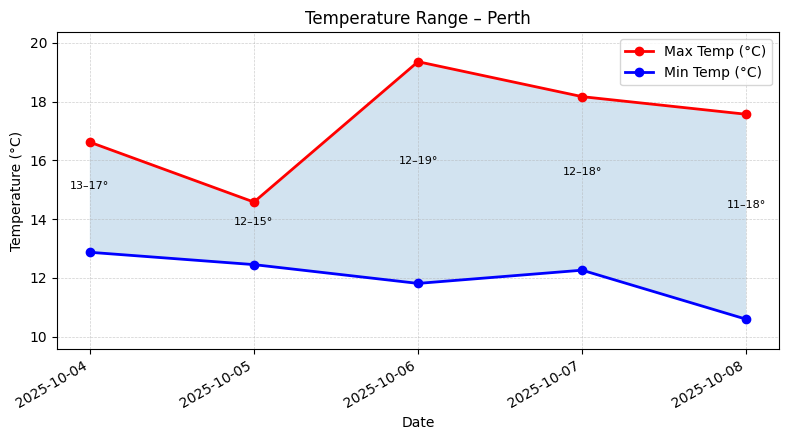

In [60]:
import matplotlib.pyplot as plt
from datetime import datetime

def create_temperature_range_visualisation(weather_data, output_type='display'):
    """
    Create a visualisation showing the daily minimum and maximum temperatures
    over the forecast period, with a shaded range area.
    Dual-line (min & max) with shaded range; robust to single-day data.

    Args:
        weather_data (dict): Processed weather data from get_weather_data().
            Expected structure:
                weather_data["daily"] = [
                    {"date":"YYYY-MM-DD","temp_min":float,"temp_max":float, ...}, ...
                ]
        output_type (str): 'display' to show the chart, or 'figure' to return the Matplotlib figure.

    Returns:
        If output_type == 'figure': returns a matplotlib.figure.Figure
        Otherwise: displays the chart and returns None
    """
    if not isinstance(weather_data, dict) or "error" in weather_data:
        print("⚠️ Cannot create visualisation: missing or invalid weather data.")
        return None

    title_location = weather_data.get("location", {}).get("name") or weather_data.get("location", "") or "Selected Location"
    daily = weather_data.get("daily") or []
    dates, tmin, tmax = [], [], []
    for row in daily:
        d, lo, hi = row.get("date"), row.get("temp_min"), row.get("temp_max")
        if d is None or lo is None or hi is None:
            continue
        dates.append(d); tmin.append(float(lo)); tmax.append(float(hi))

    if not dates:
        print("ℹ️ No temperature range data available.")
        return None

    # Sort chronologically
    try:
        pairs = sorted([(datetime.strptime(d, "%Y-%m-%d"), lo, hi) for d, lo, hi in zip(dates, tmin, tmax)], key=lambda x: x[0])
        dates = [dt.strftime("%Y-%m-%d") for dt, _, _ in pairs]
        tmin  = [lo for _, lo, _ in pairs]
        tmax  = [hi for _, _, hi in pairs]
    except Exception:
        pass

    fig, ax = plt.subplots(figsize=(8, 4.5))
    ax.plot(dates, tmax, marker='o', label="Max Temp (°C)", color="red", linewidth=2)
    ax.plot(dates, tmin, marker='o', label="Min Temp (°C)", color="blue", linewidth=2)

    # Shaded band (only if ≥2 points; otherwise fill_between can look odd)
    if len(dates) >= 2:
        ax.fill_between(dates, tmin, tmax, alpha=0.2)

    ax.set_title(f"Temperature Range – {title_location}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Temperature (°C)")
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
    ax.legend(loc="best")

    # Midpoint annotations
    for x, lo, hi in zip(dates, tmin, tmax):
        mid = (lo + hi) / 2
        ax.annotate(f"{lo:.0f}–{hi:.0f}°", xy=(x, mid), xytext=(0, 6), textcoords="offset points", ha="center", fontsize=8)

    ymin, ymax = min(tmin + tmax), max(tmin + tmax)
    if ymin == ymax: ymin -= 2; ymax += 2
    ax.set_ylim(ymin - 1.0, ymax + 1.0)

    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()
    if output_type == 'figure': return fig
    plt.show(); plt.close(fig); return None


# Sample test input using existing data dict:
data = get_weather_data("Perth,AU", forecast_days=5)
create_temperature_range_visualisation(data)

### Wind Speed and Humidity Visualisation

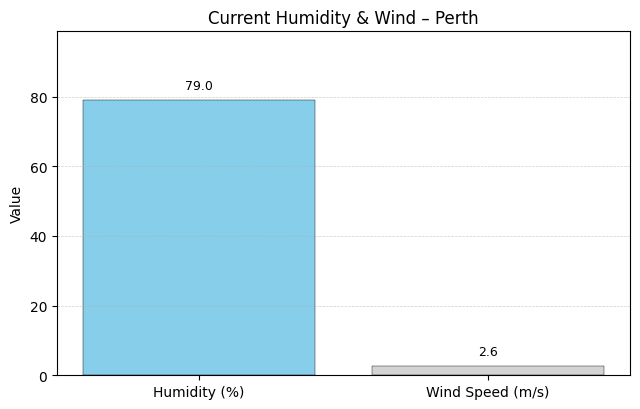

In [62]:
import matplotlib.pyplot as plt
from datetime import datetime

def create_wind_humidity_visualisation(weather_data, output_type='display'):
    """
    Create a visualisation of daily average wind speed and humidity over the forecast period.
    Two bars for current humidity (%) and wind speed (m/s) with labels and guards.

    Args:
        weather_data (dict): Processed weather data from get_weather_data().
            Expected daily structure:
                weather_data["daily"] = [
                    {"date":"YYYY-MM-DD", "temp_avg":float, "description":str, ...},
                    ...
                ]
            and optionally weather_data["current"]["humidity"], ["current"]["wind_speed"]
        output_type (str): 'display' to show the chart, or 'figure' to return the Matplotlib figure.

    Returns:
        If output_type == 'figure': returns a matplotlib.figure.Figure
        Otherwise: displays the chart and returns None
    """
    if not isinstance(weather_data, dict) or "error" in weather_data:
        print("⚠️ Cannot create visualisation: missing or invalid weather data.")
        return None

    current = weather_data.get("current") or {}
    humidity = current.get("humidity")
    wind = current.get("wind_speed")
    if humidity is None or wind is None:
        print("ℹ️ Humidity or wind speed not available in current conditions.")
        return None

    title_location = weather_data.get("location", {}).get("name") or weather_data.get("location", "") or "Selected Location"
    categories = ['Humidity (%)', 'Wind Speed (m/s)']
    values = [float(humidity), float(wind)]

    fig, ax = plt.subplots(figsize=(6.5, 4.2))
    bars = ax.bar(categories, values, color=['skyblue', 'lightgray'], edgecolor="black", linewidth=0.3)
    ax.set_title(f"Current Humidity & Wind – {title_location}")
    ax.set_ylabel("Value")
    # Y range with a little headroom
    ymax = max(values) if max(values) > 0 else 1.0
    ax.set_ylim(0, ymax * 1.25)
    ax.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.6)

    for bar in bars:
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, h + ymax*0.03, f"{h:.1f}", ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    if output_type == 'figure': return fig
    plt.show(); plt.close(fig); return None

# Sample test input using existing data dict:
data = get_weather_data("Perth,AU", forecast_days=3)
create_wind_humidity_visualisation(data)

### 24 Hour Temperature Visualisation

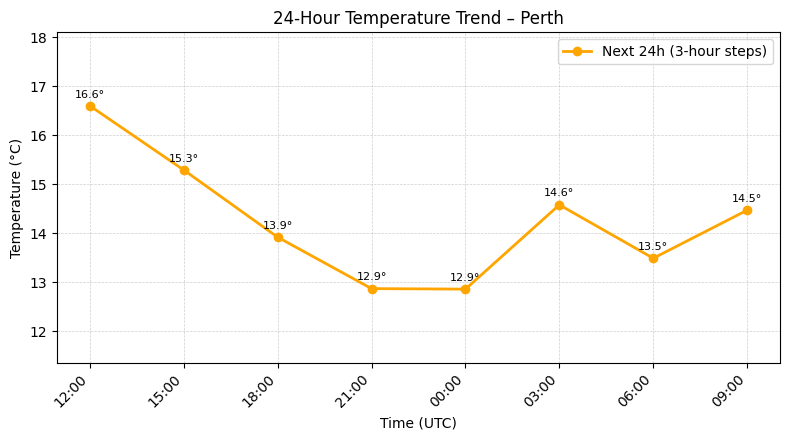

In [63]:
import matplotlib.pyplot as plt
from datetime import datetime

def create_hourly_temperature_visualisation(weather_data, output_type='display'):
    """
    Create a 24-hour temperature trend line chart using hourly forecast data.
    Line chart for next 24h temperatures (every 3h) with legend and padding.

    Args:
        weather_data (dict): Processed weather data from get_weather_data().
            Expected structure:
                weather_data["hourly_24h"] = [
                    {"dt":"YYYY-MM-DD HH:MM:SS","temp":float,"description":str}, ...
                ]
        output_type (str): 'display' to show the chart, or 'figure' to return the Matplotlib figure.

    Returns:
        If output_type == 'figure': returns a matplotlib.figure.Figure
        Otherwise: displays the chart and returns None
    """
    if not isinstance(weather_data, dict) or "error" in weather_data:
        print("⚠️ Cannot create visualisation: missing or invalid weather data.")
        return None

    hourly = weather_data.get("hourly_24h")
    if not hourly:
        print("ℹ️ Hourly data unavailable; try include_hourly_24h=True when fetching.")
        return None

    title_location = weather_data.get("location", {}).get("name") or weather_data.get("location", "") or "Selected Location"

    times, temps = [], []
    for row in hourly:
        dt_text, t = row.get("dt"), row.get("temp")
        if not dt_text or t is None:
            continue
        try:
            label = datetime.strptime(dt_text, "%Y-%m-%d %H:%M:%S").strftime("%H:%M")
        except Exception:
            label = dt_text
        times.append(label); temps.append(float(t))

    if not times or not temps:
        print("ℹ️ No valid hourly temperature data found.")
        return None

    fig, ax = plt.subplots(figsize=(8, 4.5))
    ax.plot(times, temps, marker='o', linewidth=2, color="orange", label="Next 24h (3-hour steps)")
    ax.set_title(f"24-Hour Temperature Trend – {title_location}")
    ax.set_xlabel("Time (UTC)")
    ax.set_ylabel("Temperature (°C)")
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
    ax.legend(loc="best")

    for x, y in zip(times, temps):
        ax.annotate(f"{y:.1f}°", xy=(x, y), xytext=(0, 6), textcoords="offset points", ha="center", fontsize=8)

    ymin, ymax = min(temps), max(temps)
    if ymin == ymax: ymin -= 2; ymax += 2
    ax.set_ylim(ymin - 1.5, ymax + 1.5)

    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    if output_type == 'figure': return fig
    plt.show(); plt.close(fig); return None

# Sample test input using existing data dict:
data = get_weather_data("Perth,AU", forecast_days=3)
create_hourly_temperature_visualisation(data)

## 🤖 Natural Language Processing

In [64]:
import re
from datetime import datetime, timezone, timedelta

def parse_weather_question(question: str) -> dict:
    """
    Parse a natural language weather question into structured intent.

    Extracts:
      - attribute: one of {"temperature","rain","wind","humidity","conditions"}
      - time_period: {"today","tomorrow","next_n_days"} (+ n if relevant)
      - forecast_days: int (1..5) best-effort for the attribute/time
      - location: string or None if not specified
      - question_type: {"yesno","value","summary"} crude classification
      - raw: original question (for logging/debug)

    Examples:
      "Will it rain tomorrow in Perth?" ->
        {"attribute":"rain","time_period":"tomorrow","forecast_days":2,
         "location":"Perth","question_type":"yesno"}

      "What's the temperature for the next 3 days in Sydney, AU?" ->
        {"attribute":"temperature","time_period":"next_n_days","n":3,
         "forecast_days":3,"location":"Sydney, AU","question_type":"value"}
    """
    if not isinstance(question, str) or not question.strip():
        return {"error": "Empty question.", "raw": question}

    q_raw = question.strip()
    q = q_raw.lower()

    # ---- attribute detection ----
    attr = None
    if re.search(r"\b(temp|temperature|hot|cold|warm|cool)\b", q):
        attr = "temperature"
    elif re.search(r"\b(rain|rainy|shower|precip|umbrella)\b", q):
        attr = "rain"
    elif re.search(r"\b(wind|windy|gust)\b", q):
        attr = "wind"
    elif re.search(r"\b(humidity|humid)\b", q):
        attr = "humidity"
    elif re.search(r"\b(weather|forecast|clear|cloud|sunny|storm|snow|overcast)\b", q):
        attr = "conditions"
    else:
        # default to conditions if completely unspecified
        attr = "conditions"

    # ---- time period detection ----
    time_period = None
    n_days = None

    if re.search(r"\btoday\b", q):
        time_period = "today"
    elif re.search(r"\btomorrow\b", q):
        time_period = "tomorrow"
    else:
        # next N days
        m = re.search(r"\bnext\s+(\d+)\s*(day|days)\b", q)
        if m:
            n_days = max(1, min(int(m.group(1)), 5))
            time_period = "next_n_days"
        elif re.search(r"\bnext\s+few\s+days\b", q):
            n_days = 3
            time_period = "next_n_days"
        elif re.search(r"\bthis\s+week(end)?\b", q):
            # keep it simple for v1: map to 3 days
            n_days = 3
            time_period = "next_n_days"

    # default time period if none found
    if not time_period:
        # yes/no questions without explicit time often imply "today" or "soon"
        time_period = "today"

    # choose forecast_days (for API/daily usage)
    if time_period == "today":
        forecast_days = 1
    elif time_period == "tomorrow":
        forecast_days = 2  # fetch at least 2 so index 1 exists if needed
    elif time_period == "next_n_days":
        forecast_days = n_days or 3
    else:
        forecast_days = 3

    forecast_days = max(1, min(int(forecast_days), 5))

    # ---- question type ----
    question_type = "value"
    if re.match(r"\s*(will|is|are|do|does|should|can|could)\b", q):
        question_type = "yesno"
    elif re.search(r"\bforecast|weather\b", q) and attr == "conditions":
        question_type = "summary"

    # ---- location extraction ----
    # 1) common pattern: "in <location...>"
    loc = None
    m_in = re.search(r"\bin\s+([a-z0-9 .,\-']+)$", q, flags=re.I)
    if not m_in:
        m_in = re.search(r"\bin\s+([a-z0-9 .,\-']+?)(\?|\!|\.|$)", q, flags=re.I)
    if m_in:
        loc = m_in.group(1).strip(" ?!.,")
    else:
        # 2) pattern: "... for <location>"
        m_for = re.search(r"\bfor\s+([a-z0-9 .,\-']+?)(\?|\!|\.|$)", q, flags=re.I)
        if m_for:
            loc = m_for.group(1).strip(" ?!.,")
        else:
            # 3) trailing capitalized phrase heuristic (very light)
            #    e.g., "What about Perth, AU?"
            m_tail = re.search(r"([A-Z][A-Za-z .,'\-]+(?:,[ ]?[A-Z]{2})?)\s*[?!.]*$", q_raw)
            if m_tail and len(m_tail.group(1).split()) <= 4:
                loc = m_tail.group(1).strip()

    # normalize a bit
    if loc:
        loc = re.sub(r"\s+", " ", loc)

    return {
        "attribute": attr,
        "time_period": time_period,
        "n": n_days,
        "forecast_days": forecast_days,
        "location": loc,          # may be None; caller can provide default
        "question_type": question_type,
        "raw": q_raw
    }

In [65]:
def generate_weather_response(parsed_question: dict, weather_data: dict) -> str:
    """
    Turn parsed intent + fetched weather_data into a natural-language reply.

    Expects weather_data from get_weather_data(). Handles:
      - attribute-specific phrasing (temperature, rain, wind, humidity, conditions)
      - time periods (today, tomorrow, next_n_days)
      - missing data / provider errors gracefully
    """
    # ---- guard rails ----
    if not isinstance(parsed_question, dict):
        return "Sorry, I couldn't understand the question format."
    if not isinstance(weather_data, dict):
        return "Sorry, I couldn't access weather information at the moment."

    # provider/UI error
    if "error" in weather_data:
        msg = weather_data["error"].get("message", "An unknown error occurred.")
        hint = weather_data["error"].get("hint")
        return f"Sorry, I couldn't retrieve the weather. {msg}" + (f" Hint: {hint}" if hint else "")

    attr = parsed_question.get("attribute") or "conditions"
    period = parsed_question.get("time_period") or "today"
    n_days = parsed_question.get("n")
    qtype = parsed_question.get("question_type", "value")

    loc_name = weather_data.get("location", {}).get("name") or weather_data.get("location") or "the selected location"
    current = weather_data.get("current") or {}
    daily = weather_data.get("daily") or []

    # Helper: pick day index
    # Note: your 'daily' list is the *future* days (UTC), often starting from tomorrow.
    idx_tomorrow = 0 if len(daily) >= 1 else None

    def fmt_deg(v):
        try: return f"{float(v):.1f}°C"
        except: return "N/A"

    def fmt_pct(v):
        try: return f"{float(v):.0f}%"
        except: return "N/A"

    # ---- handle each attribute ----
    if period == "today":
        # TODAY: lean on 'current' snapshot + a hint from first daily if available
        if attr == "temperature":
            cur = current.get("temp")
            desc = current.get("description", "").lower()
            return f"Right now in {loc_name} it's {fmt_deg(cur)} and {desc or '—'}."

        elif attr == "rain":
            # Use next day POP if today's POP not available; otherwise infer from description
            if daily:
                pop = daily[0].get("pop", 0.0)
                answer = f"The chance of rain today in {loc_name} is about {fmt_pct(pop)}."
            else:
                desc = (current.get("description") or "").lower()
                likely = "likely" if any(k in desc for k in ["rain","shower"]) else "unlikely"
                answer = f"Rain is {likely} today in {loc_name} based on current conditions."
            if qtype == "yesno":
                return ("Yes" if (daily and daily[0].get("pop",0)>=50) else "Probably not") + f" — {answer}"
            return answer

        elif attr == "wind":
            ws = current.get("wind_speed")
            return f"Current wind in {loc_name} is {ws:.1f} m/s." if ws is not None else f"Wind data isn't available for {loc_name} right now."

        elif attr == "humidity":
            h = current.get("humidity")
            return f"Humidity in {loc_name} is {h}%." if h is not None else f"Humidity data isn't available for {loc_name} right now."

        else:  # conditions
            desc = current.get("description")
            if desc:
                return f"Currently in {loc_name}: {desc}, {fmt_deg(current.get('temp'))}."
            return f"Sorry, I couldn't determine current conditions for {loc_name}."

    elif period == "tomorrow":
        if idx_tomorrow is None:
            return f"Sorry, I don't have a forecast for tomorrow in {loc_name}."

        d = daily[idx_tomorrow]
        date = d.get("date", "tomorrow")
        if attr == "temperature":
            return (f"Tomorrow ({date}) in {loc_name}: {fmt_deg(d.get('temp_avg'))} on average "
                    f"(min {fmt_deg(d.get('temp_min'))}, max {fmt_deg(d.get('temp_max'))}).")
        elif attr == "rain":
            pop = d.get("pop", 0.0)
            if qtype == "yesno":
                return ("Yes" if pop >= 50 else "Probably not") + f". Chance of rain tomorrow ({date}) in {loc_name} is {fmt_pct(pop)}."
            return f"Chance of rain tomorrow ({date}) in {loc_name} is {fmt_pct(pop)}."
        elif attr == "wind":
            # We don't have daily wind in the free 2.5 feed; give a helpful note
            return (f"I don’t have reliable daily wind speeds for tomorrow in {loc_name} with this data source. "
                    f"You can check current wind ({current.get('wind_speed','N/A')} m/s) or the 24-hour chart.")
        elif attr == "humidity":
            return (f"I don’t have daily humidity for tomorrow in {loc_name} from this feed. "
                    f"Current humidity is {current.get('humidity','N/A')}%.")
        else:
            return f"Tomorrow ({date}) in {loc_name} looks {d.get('description','—').lower()} around {fmt_deg(d.get('temp_avg'))}."

    elif period == "next_n_days":
        k = max(1, min(int(n_days or 3), 5))
        if not daily:
            return f"Sorry, I don’t have a multi-day forecast for {loc_name}."
        days = daily[:k]
        if attr == "temperature":
            parts = [f"{d['date']}: avg {fmt_deg(d['temp_avg'])} (min {fmt_deg(d['temp_min'])}, max {fmt_deg(d['temp_max'])})" for d in days]
            return f"Next {k} days in {loc_name}:\n- " + "\n- ".join(parts)
        elif attr == "rain":
            parts = [f"{d['date']}: {fmt_pct(d.get('pop',0))}" for d in days]
            return f"Chance of rain over the next {k} days in {loc_name}:\n- " + "\n- ".join(parts)
        elif attr == "wind":
            return (f"I don’t have daily wind forecasts in this feed. "
                    f"Try the 24-hour temperature chart and current wind ({current.get('wind_speed','N/A')} m/s).")
        elif attr == "humidity":
            return (f"I don’t have daily humidity forecasts in this feed. "
                    f"Current humidity is {current.get('humidity','N/A')}% in {loc_name}.")
        else:
            parts = [f"{d['date']}: {d.get('description','—').lower()}, around {fmt_deg(d.get('temp_avg'))}" for d in days]
            return f"Summary for the next {k} days in {loc_name}:\n- " + "\n- ".join(parts)

    # Fallback
    return f"Here’s the current snapshot for {loc_name}: {current.get('summary','N/A')}"

In [67]:
# Sample test

# 1) Parse the user’s question
pq = parse_weather_question("Will it rain tomorrow in Perth?")

# 2) Decide the location & days for fetching (use default if None)
loc = pq.get("location") or "Perth,AU"
days = pq.get("forecast_days", 3)

# 3) Fetch weather (your existing function)
data = get_weather_data(loc, forecast_days=days)

# 4) Generate response
reply = generate_weather_response(pq, data)
print(reply)

Yes. Chance of rain tomorrow (2025-10-04) in Perth is 92%.


## 🧭 User Interface

In [68]:
# User Interface (pyinputplus)
import pyinputplus as pyip
import json
from textwrap import dedent

# ---- Global default (change if you like) ----
DEFAULT_LOCATION = "Perth,AU"

# ---- Small UI helpers ----
def ui_header(title: str):
    print("\n" + "=" * 60)
    print(title)
    print("=" * 60)

def ui_info(msg: str):
    print(f"ℹ️  {msg}")

def ui_ok(msg: str):
    print(f"✅ {msg}")

def ui_warn(msg: str):
    print(f"⚠️ {msg}")

def ui_err(msg: str):
    print(f"❌ {msg}")

def ui_press_enter():
    input("\n(Press Enter to continue) ")

# ---- Input helpers with validation ----
def ui_get_city(default_location=DEFAULT_LOCATION):
    city = pyip.inputStr(
        prompt=f"Enter city (e.g., 'Sydney,AU') [Default: {default_location}]: ",
        blank=True
    ).strip()
    if not city:
        ui_info(f"No city entered. Using default: {default_location}")
        city = default_location
    return city

def ui_get_days(default=3):
    days = pyip.inputInt(
        prompt=f"Forecast days (1-5) [Default: {default}]: ",
        min=1, max=5, blank=True
    )
    if days == '':
        days = default
    return int(days or default)

# ---- Pretty text renderers (no plotting) ----
def ui_show_current_summary(data: dict):
    loc = data["location"]["name"]
    print(f"\n— Current in {loc} —")
    print(data["current"]["summary"])
    # optional extras
    tz = data["location"].get("timezone_offset_seconds", 0)
    print(f"Timezone offset: {tz//3600:+d}h")

def ui_show_daily_table(data: dict):
    print("\n— Daily Forecast —")
    if not data.get("daily"):
        ui_info("No daily forecast available.")
        return
    for d in data["daily"]:
        print(f"{d['date']}: {d['description']} | avg {d['temp_avg']}°C "
              f"(min {d['temp_min']}°C, max {d['temp_max']}°C) | rain {d['pop']}%")

# ---- Dashboard flow (fetch once, then show multiple outputs) ----
def ui_dashboard():
    ui_header("Weather Dashboard")
    city = ui_get_city()
    days = ui_get_days(default=5)
    ui_info(f"Fetching {days}-day forecast for {city} ...")
    data = get_weather_data(city, forecast_days=days, include_hourly_24h=True)

    if not isinstance(data, dict) or "error" in data:
        ui_err(data.get("error", {}).get("message", "Unable to fetch weather."))
        hint = data.get("error", {}).get("hint")
        if hint:
            ui_info(hint)
        ui_press_enter()
        return

    ui_ok("Data retrieved successfully.")
    ui_show_current_summary(data)
    ui_show_daily_table(data)

    # Offer quick visuals
    while True:
        print("\nWhat would you like to visualise?")
        choice = pyip.inputMenu(
            ["Temperature Trend", "Precipitation Probability", "Temperature Range (Min–Max)",
             "Wind & Humidity (Current)", "24-Hour Temperature", "Back to Main Menu"],
            numbered=True
        )
        try:
            if choice == "Temperature Trend":
                create_temperature_visualisation(data)
            elif choice == "Precipitation Probability":
                create_precipitation_visualisation(data)
            elif choice == "Temperature Range (Min–Max)":
                create_temperature_range_visualisation(data)
            elif choice == "Wind & Humidity (Current)":
                create_wind_humidity_visualisation(data)
            elif choice == "24-Hour Temperature":
                create_hourly_temperature_visualisation(data)
            else:
                break
        except Exception as e:
            ui_warn(f"Couldn't render the chart: {e}")
        # keep the loop so users can view multiple charts from a single fetch

# ---- Quick fetch (debug/inspection) ----
def ui_quick_fetch():
    ui_header("Quick Fetch (Debug)")
    city = ui_get_city()
    days = ui_get_days(default=3)
    ui_info(f"Fetching {days}-day forecast for {city} ...")
    data = get_weather_data(city, forecast_days=days, include_hourly_24h=True)
    if not isinstance(data, dict) or "error" in data:
        ui_err(data.get("error", {}).get("message", "Unable to fetch weather."))
        hint = data.get("error", {}).get("hint")
        if hint:
            ui_info(hint)
        ui_press_enter()
        return
    print("\nPreview:")
    print(json.dumps(data, indent=2)[:1200], "...")
    ui_press_enter()

# ---- Chat mode (uses NLP if available) ----
def ui_chat():
    ui_header("Chat Mode")
    # Check for NLP functions
    have_parse = 'parse_weather_question' in globals()
    have_generate = 'generate_weather_response' in globals()
    if not (have_parse and have_generate):
        ui_warn("Natural language features are not available yet in this notebook.")
        ui_press_enter()
        return

    default_loc = DEFAULT_LOCATION
    print(dedent(f"""
      Type your weather question, e.g.:
      - "Will it rain tomorrow in Sydney?"
      - "Show temperature for the next 3 days in Melbourne"
      - "What's the weather today?"
      Type 'back' to return to the main menu.
      (Default location used if none is detected: {default_loc})
    """))

    while True:
        q = pyip.inputStr("You: ").strip()
        if q.lower() in {"back", "exit", "quit"}:
            break

        parsed = parse_weather_question(q)
        if "error" in parsed:
            ui_warn(parsed["error"])
            continue

        loc = parsed.get("location") or default_loc
        days = parsed.get("forecast_days", 3)
        data = get_weather_data(loc, forecast_days=days, include_hourly_24h=True)
        answer = generate_weather_response(parsed, data)
        print("\nAssistant:", answer)

        # Optional: suggest a visual based on attribute/time
        if isinstance(data, dict) and "error" not in data:
            attr = (parsed.get("attribute") or "").lower()
            period = parsed.get("time_period")
            try:
                if "temperature" in attr and period == "next_n_days":
                    create_temperature_visualisation(data)
                elif "temperature" in attr and period in {"today","tomorrow"}:
                    create_temperature_range_visualisation(data)
                elif "rain" in attr:
                    create_precipitation_visualisation(data)
                elif "wind" in attr or "humidity" in attr:
                    create_wind_humidity_visualisation(data)
                elif period == "today" and "hourly_24h" in data:
                    create_hourly_temperature_visualisation(data)
            except Exception as e:
                ui_warn(f"Couldn't render a related chart: {e}")
        print()

# ---- Main menu / flow ----
def run_app():
    while True:
        ui_header("Weather Wise — Main Menu")
        choice = pyip.inputMenu(
            ["Dashboard", "Chat", "Quick Fetch (Debug)", "Settings", "Exit"],
            numbered=True
        )
        if choice == "Dashboard":
            ui_dashboard()
        elif choice == "Chat":
            ui_chat()
        elif choice == "Quick Fetch (Debug)":
            ui_quick_fetch()
        elif choice == "Settings":
            ui_settings()
        else:
            ui_info("Goodbye!")
            break

def ui_settings():
    global DEFAULT_LOCATION
    ui_header("Settings")
    print(f"Current default location: {DEFAULT_LOCATION}")
    new_loc = pyip.inputStr("Set new default location (blank to keep current): ", blank=True).strip()
    if new_loc:
        DEFAULT_LOCATION = new_loc
        ui_ok(f"Default location set to: {DEFAULT_LOCATION}")
    else:
        ui_info("Default location unchanged.")
    ui_press_enter()

In [ ]:
# Launch UI
run_app()

## 🧩 Main Application Logic

In [ ]:
# Tie everything together here
def generate_weather_response(parsed_question, weather_data):
    """
    Generate a natural language response to a weather question.

    Args:
        parsed_question (dict): Parsed question data
        weather_data (dict): Weather data

    Returns:
        str: Natural language response
    """
    pass

## 🧪 Testing and Examples

In [ ]:
# Include sample input/output for each function

## 🗂️ AI Prompting Log (Optional)
Add markdown cells here summarising prompts used or link to AI conversations in the `ai-conversations/` folder.